Import libs and modules

In [28]:
import string

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from PIL import Image

from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer

Reading dataset

In [29]:
df = pd.read_csv('asteroids.csv')[:10000]

numeric_columns = ['absolute_magnitude', 'estimated_diameter_min', 'estimated_diameter_max', 
                   'relative_velocity', 'miss_distance']

scaler = StandardScaler()

X_std = scaler.fit_transform(df[numeric_columns])

Dimension reduction and visualisation

PCA

In [30]:
pca = PCA()
X_pca = pca.fit_transform(X_std)

In [31]:
exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

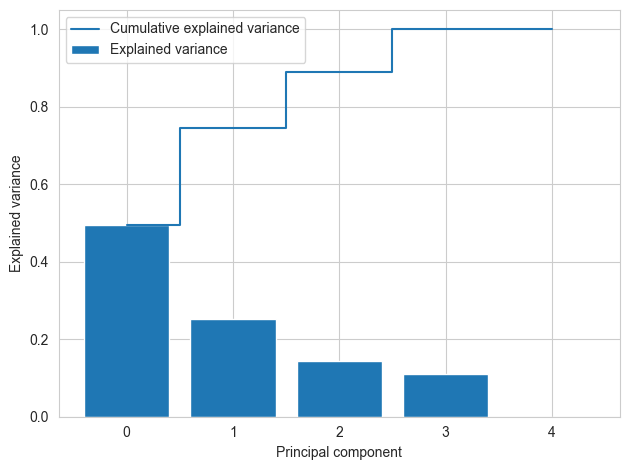

In [32]:
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, align='center', label='Explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance')
plt.xlabel('Principal component')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

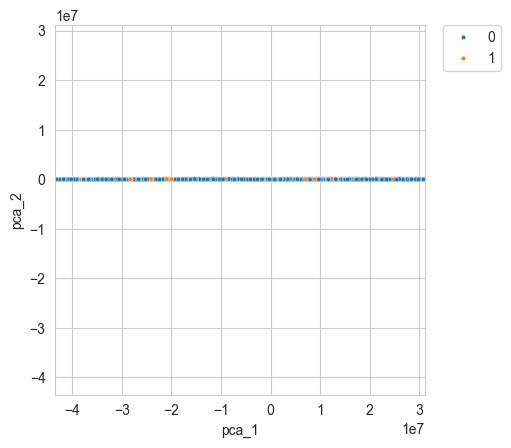

In [33]:
X = df[numeric_columns]
y = df['is_hazardous']

pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)

pca_result_df = pd.DataFrame({'pca_1': pca_result[:,0], 'pca_2': pca_result[:,1], 'label': y})

fig, ax = plt.subplots(1)
sns.scatterplot(x='pca_1', y='pca_2', hue='label', data=pca_result_df, ax=ax,s=10)
lim = (pca_result.min()-5, pca_result.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

TSNE

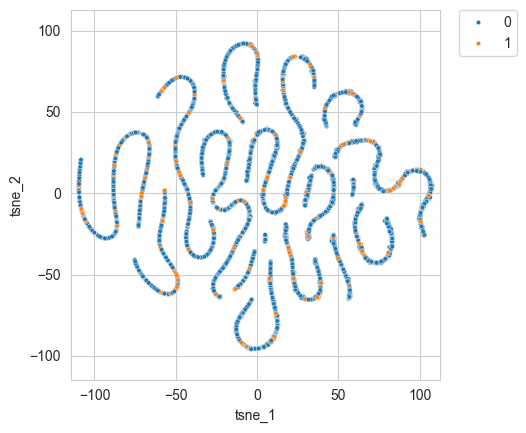

In [34]:
tsne = TSNE(n_components=2)
tsne_result = tsne.fit_transform(X)

tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': y})

fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax,s=10)
lim = (tsne_result.min()-5, tsne_result.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

Cluster analysis

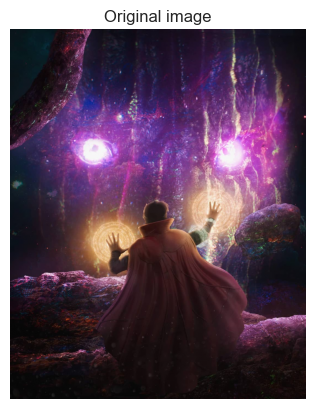

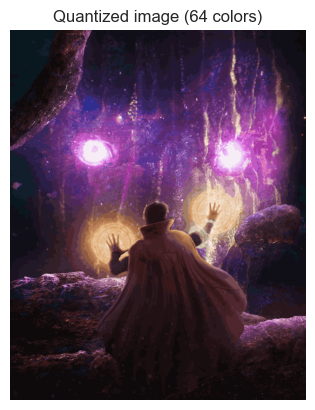

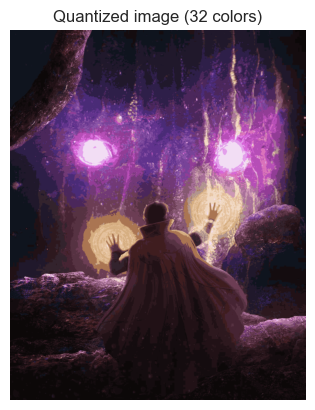

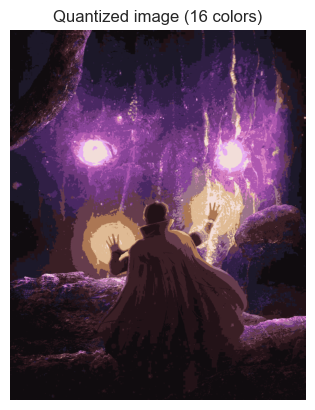

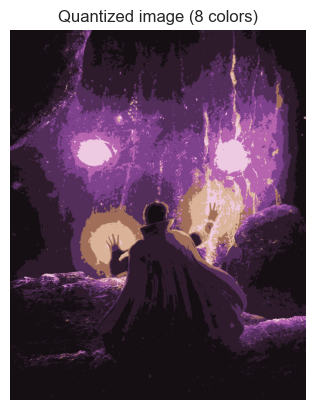

In [35]:
def load_custom_image(path):
    img = Image.open(path)
    img = img.convert("RGB")
    img = np.array(img, dtype=np.float64) / 255
    return img

image_path = 'pic.jpg'
image = load_custom_image(image_path)

w, h, d = original_shape = tuple(image.shape)
assert d == 3
image_array = np.reshape(image, (w * h, d))

def quantize_and_display(image_array, n_colors, w, h):
    
    image_array_sample = shuffle(image_array, random_state=0, n_samples=1_000)
    kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample)
    
    labels = kmeans.predict(image_array)

    quantized_image = recreate_image(kmeans.cluster_centers_, labels, w, h)

    plt.figure()
    plt.axis("off")
    plt.title(f"Quantized image ({n_colors} colors)")
    plt.imshow(quantized_image)


def recreate_image(codebook, labels, w, h):
    return codebook[labels].reshape(w, h, -1)

plt.figure()
plt.axis("off")
plt.title("Original image")
plt.imshow(image)

for n_colors in [64, 32, 16, 8]:
    quantize_and_display(image_array, n_colors, w, h)

plt.show()


New dataset and cleanup

In [36]:
import string
import re

def clear_text(text):
    text = re.sub("@\S+", " ", text)
    text = re.sub("https*\S+", " ", text)
    text = re.sub("#\S+", " ", text)
    text = re.sub("\d", " ", text)
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\n', ' ', text)
    text = re.sub('\s{2,}',' ', text)
    text = text.lower()
    text = ' '.join([word for word in text.split(' ') if word not in stop_words])
    return text

df2 = pd.read_csv('reviews.csv')
print(df2.shape)
print(df2.head())
stop_words = stopwords.words('english')

df_clean = df2[['review', 'voted_up']].copy()
df_clean = df_clean.dropna()
print(df_clean.shape)

df_clean['review'] = df_clean['review'].apply(clear_text)

print(df_clean.head())

(309103, 13)
   recommendationid language  \
0         153560814  english   
1         153560623  english   
2         153560414  english   
3         153560343  english   
4         153559963  english   

                                              review  timestamp_created  \
0          This game hits all the right marks. 10/10         1702542971   
1     took me like 11 hours to understand the basics         1702542657   
2  10/10 game play and story! It's my first turn ...         1702542275   
3                               gale is so baby girl         1702542158   
4                    YES,\n\nWITHOUT A F****N DOUBT.         1702541518   

   timestamp_updated  voted_up  votes_up  votes_funny  weighted_vote_score  \
0         1702542971      True         0            0                  0.0   
1         1702542657      True         0            0                  0.0   
2         1702542275      True         0            0                  0.0   
3         1702542158      True 

Splitting based on review and creating wordcloud

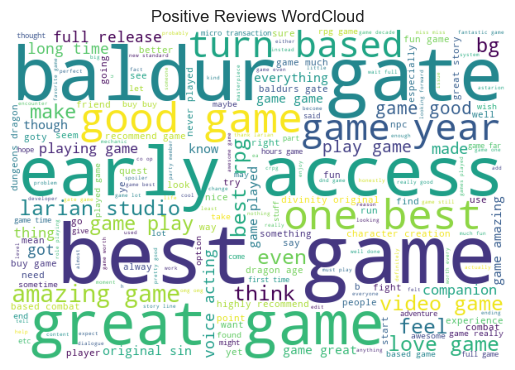

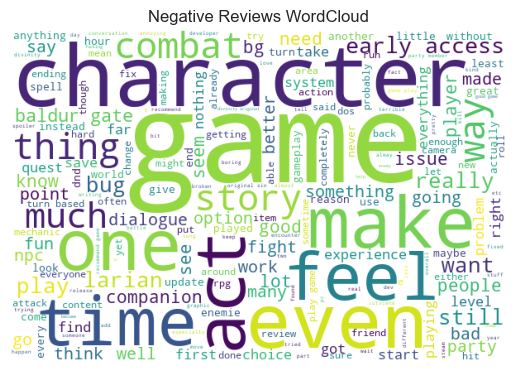

In [37]:
positive_reviews = df_clean[df_clean['voted_up'] == True]['review'].values
negative_reviews = df_clean[df_clean['voted_up'] == False]['review'].values

def plot_wordcloud(text, title): 
    wordcloud = WordCloud(width=600, height=400, background_color='white').generate(' '.join(text))
    plt.imshow(wordcloud)
    plt.title(title)
    plt.axis('off')
    plt.show()

plot_wordcloud(positive_reviews, 'Positive Reviews WordCloud')
plot_wordcloud(negative_reviews, 'Negative Reviews WordCloud')

Vectorisation, classification using Logistic Regression and quality assessment

In [38]:
df_clean['voted_up'] = df_clean['voted_up'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(df_clean['review'], df_clean['voted_up'], test_size=0.2)

tfidf_vectorizer = TfidfVectorizer(max_df=500, min_df=10)

tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

clf = LogisticRegression().fit(tfidf_train, y_train)

predicted = clf.predict(tfidf_test)

print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.67      0.16      0.26      1985
           1       0.97      1.00      0.98     59633

    accuracy                           0.97     61618
   macro avg       0.82      0.58      0.62     61618
weighted avg       0.96      0.97      0.96     61618

